In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import warnings

path = 'housing.csv'
housing = pd.DataFrame(pd.read_csv(path))
housing.head()


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [166]:
# List of variables to map

varlist =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']

# Defining the map function
def binary_map(x):
    return x.map({'yes': 1, 'no': 0, 'unfurnished': 0, 'semi-furnished': 1, 'furnished': 2})

# Applying the function to the housing list
housing[varlist] = housing[varlist].apply(binary_map)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,2
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,2
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,2
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,2


In [167]:
np.random.seed(10)
df_train, df_validate = train_test_split(housing, train_size=0.8, test_size=0.2, random_state=100)

y_train = df_train.pop('price')
X_train = df_train

y_validate = df_validate.pop('price')
X_validate = df_validate
X_train.head()

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
22,8050,3,1,1,1,1,1,0,1,1,0,2
41,6360,3,2,4,1,0,0,0,1,0,1,2
91,6750,2,1,1,1,1,1,0,0,2,1,2
118,6420,3,1,1,1,0,1,0,1,0,1,2
472,3630,4,1,2,1,0,0,0,0,3,0,1


In [168]:
a_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
X_a = housing[a_vars]
X_train_df_a = X_train[a_vars]
X_validate_df_a = X_validate[a_vars]
X_train_df_a.head()

,area,bedrooms,bathrooms,stories,parking
22,8050,3,1,1,1
41,6360,3,2,4,0
91,6750,2,1,1,2
118,6420,3,1,1,0
472,3630,4,1,2,3


In [169]:
def gen_data(df: pd.DataFrame):
    if isinstance(df, pd.DataFrame):
        data = df.to_numpy()
    data = df
    X0 = np.ones((data.shape[0], 1))
    X = np.hstack((X0, data))
    return X
X_train_a = gen_data(X_train_df_a)
X_validate_a = gen_data(X_validate_df_a)

Y_train = y_train.to_numpy().reshape(-1,1)
Y_validate = y_validate.to_numpy().reshape(-1,1)

In [170]:
# vars: Area, bedrooms, bathrooms, stories, mainroad, guestroom, basement, hotwaterheating, airconditioning, parking, prefarea
b_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea']
X_b = housing[b_vars]
X_train_df_b = X_train[b_vars]
X_validate_df_b = X_validate[b_vars]

X_train_b = gen_data(X_train_df_b)
X_validate_b = gen_data(X_validate_df_b)

In [171]:
norm_a = MinMaxScaler()
norm_a.fit(X_a)
std_a = StandardScaler()
std_a.fit(X_a)
norm_b = MinMaxScaler()
norm_b.fit(X_b)
std_b = StandardScaler()
std_b.fit(X_b)

X_scaled: dict[str, pd.DataFrame] = {
    "train_a_norm" : X_train_df_a,
    "train_a_std" : X_train_df_a,
    "validate_a_norm" : X_validate_df_a,
    "validate_a_std" : X_validate_df_a,
    
    "train_b_norm" : X_train_df_b,
    "train_b_std" : X_train_df_b,
    "validate_b_norm" : X_validate_df_b,
    "validate_b_std" : X_validate_df_b,
}

for key, value in X_scaled.items():
    if "_a_" in key:
        value = gen_data(norm_a.transform(value)) if "norm" in key else gen_data(std_a.transform(value))
        
    else:
        value = gen_data(norm_b.transform(value)) if "norm" in key else gen_data(std_b.transform(value))
    X_scaled[key] = value

In [172]:
def compute_cost(X, Y, theta):
    m = X.shape[0]
    predictions = X.dot(theta)
    errors = np.subtract(predictions, Y)
    sqrErrors = np.square(errors)
    J = (1/ (2*m) ) * np.sum(sqrErrors)
    
    return J
def compute_regularized_cost(X, Y, theta, lambda_val):
    m = X.shape[0]
    predictions = X.dot(theta)
    errors = np.subtract(predictions, Y)
    sqrErrors = np.square(errors)
    J = (1/ (2*m) ) * np.sum(sqrErrors) + lambda_val * np.sum(np.square(theta))
    
    return J
    
def grad_desc(X_train: np.ndarray, Y_train: np.ndarray, theta: np.ndarray, alpha: float, iterations: int, X_val: np.ndarray, Y_val: np.ndarray, lambda_val=0):
    m = len(Y_train)
    
    training_cost_history = np.zeros(iterations)
    validation_cost_history = np.zeros(iterations)
    
    for i in range(iterations):
        validation_cost_history[i] = compute_cost(X_val, Y_val, theta)
        
        predictions = X_train.dot(theta)
        errors = np.subtract(predictions, Y_train)
        
        gradient = (1/m)*(X_train.T.dot(errors)) + lambda_val * theta
        
        theta -= alpha * gradient
        
        sqrErrors = np.square(errors)
        training_cost_history[i]= (1/(2*m)) * np.sum(sqrErrors) + lambda_val * np.sum(np.square(theta))
    
    return theta,training_cost_history, validation_cost_history


In [173]:
def print_model(X, Y, theta, name='Y', return_cost = False):
    
    cost = compute_cost(X,Y,theta)
    
    model_str = ""
    
    for i in range(theta.shape[0]-1, -1, -1):
        if i == 0:
            model_str += f"{round(theta[i,0], 3)}"
            break
        model_str += f"{round(theta[i,0], 3)}*X{i} + "
    
    print(f"Model:\n    {name} = {model_str}") 
    cost = np.sqrt(cost)
    cost_str = "{:e}".format(round(cost,5))
    
    print(f"    cost = {cost_str}")
    if return_cost:
        return cost

def display_loss(iters, train_hist, val_hist, title):
    train_hist = np.sqrt(train_hist)
    val_hist = np.sqrt(val_hist)
    plt.plot(range(iters), train_hist, label = "Training")
    plt.plot(range(iters), val_hist, label = "Validation")
    plt.title(title)
    plt.xlabel("Iteration")
    plt.ylabel("Cost")
    plt.legend()
    
    

In [174]:
#Used to find max iters before overflow error
def find_iters(X_train_b, Y_train, theta, alpha, X_validate_b, Y_validate):
    alpha = 0.01
    for iterations in range(1,50):
        theta = np.zeros((X_train_b.shape[1], 1))
        with warnings.catch_warnings(record=True) as w:
            
            warnings.filterwarnings(   
                action = 'default',
                module=__name__
            )
            
            theta, _, _ = grad_desc(X_train_b, Y_train, theta, alpha, iterations, X_validate_b, Y_validate)
            
            if w:
                print(w[-1].message)
                print(f"error at {iterations} iters")
                break
    return iterations
            


Model:
    Y = 2.5191760787463457e+136*X5 + 5.438777366196307e+136*X4 + 3.927495715894537e+136*X3 + 8.801161606152165e+136*X2 + 1.783550252099942e+140*X1 + 2.951642835906598e+136
    cost = 7.109740e+143


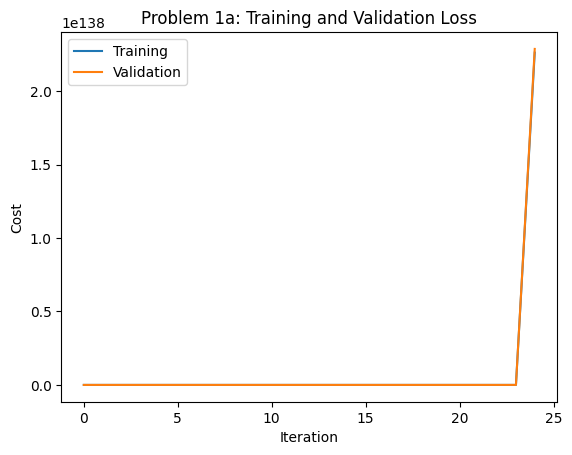

In [175]:
# Problem 1a

theta = np.zeros((X_train_a.shape[1], 1))

# 26 iters was found to be the maximum number of iterations before overflow occured
iterations_1 = 25
# Alpha of 0.01 minimizes cost
alpha = 0.01

theta, training_cost_history, validation_cost_history = grad_desc(X_train_a, Y_train, theta, alpha, iterations_1, X_validate_a, Y_validate)

display_loss(iterations_1, training_cost_history, validation_cost_history, "Problem 1a: Training and Validation Loss")
print_model(X_validate_a, Y_validate, theta)

Model:
    Y = 7.970833567858981e+135*X11 + 2.5191780578038154e+136*X10 + 1.0032272560613386e+136*X9 + 1.6384988887492037e+135*X8 + 1.0884862411168729e+136*X7 + 5.806913272122383e+135*X6 + 2.675815178198042e+136*X5 + 5.438781651600359e+136*X4 + 3.927498807751445e+136*X3 + 8.801168536401044e+136*X2 + 1.7835516508148312e+140*X1 + 2.9516451603568797e+136
    cost = 7.109746e+143


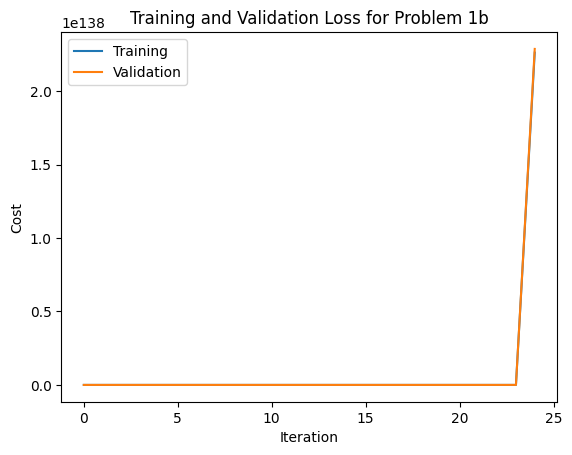

In [176]:
# Problem 1b

warnings.simplefilter("ignore")

theta = np.zeros((X_train_b.shape[1], 1))

# 26 iters was found to be the maximum number of iterations before overflow occured
iterations_1 = 25
# Alpha of 0.01 minimizes cost
alpha = 0.01

theta, training_cost_history, validation_cost_history = grad_desc(X_train_b, Y_train, theta, alpha, iterations_1, X_validate_b, Y_validate)

display_loss(iterations_1, training_cost_history, validation_cost_history, "Training and Validation Loss for Problem 1b")
print_model(X_validate_b, Y_validate, theta)

Model:
    Y = 1131909.199*X5 + 1580247.153*X4 + 3539905.434*X3 + 917849.464*X2 + 4361355.416*X1 + 2340929.343
    cost = 8.802639e+05


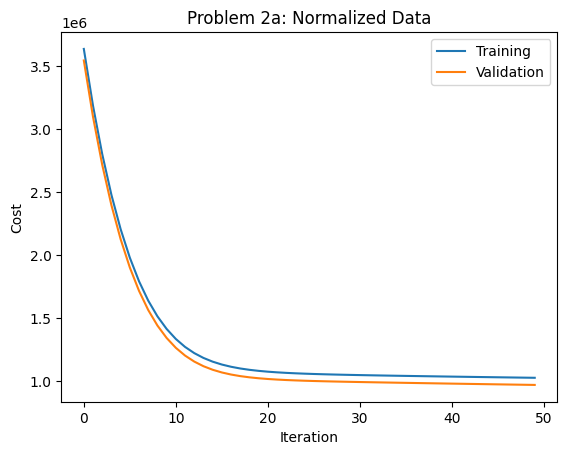

In [177]:
X_train = X_scaled["train_a_norm"]
X_validate = X_scaled["validate_a_norm"]

theta = np.zeros((X_train.shape[1], 1))

iterations = 1000
alpha = .1

theta, training_cost_history, validation_cost_history = grad_desc(X_train, Y_train, theta, alpha, iterations, X_validate, Y_validate)

display_loss(50, training_cost_history[:50], validation_cost_history[:50], "Problem 2a: Normalized Data")
cost_2_a_norm = print_model(X_validate, Y_validate, theta, return_cost=True)
val_2_a_norm = validation_cost_history


Model:
    Y = 287090.845*X5 + 456136.395*X4 + 640887.326*X3 + 80271.97*X2 + 736562.243*X1 + 4773808.357
    cost = 8.934580e+05


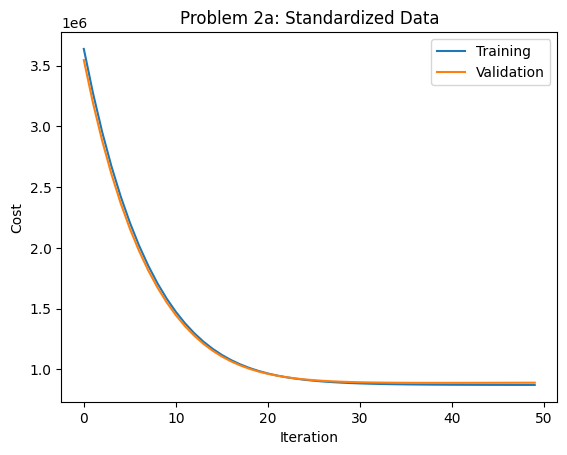

In [178]:
X_train = X_scaled["train_a_std"]
X_validate = X_scaled["validate_a_std"]

theta = np.zeros((X_train.shape[1], 1))

iterations = 1000
alpha = .1

theta, training_cost_history, validation_cost_history = grad_desc(X_train, Y_train, theta, alpha, iterations, X_validate, Y_validate)

display_loss(50, training_cost_history[:50], validation_cost_history[:50], "Problem 2a: Standardized Data")
cost_2a_std = print_model(X_validate, Y_validate, theta, return_cost=True)

Model:
    Y = 632916.665*X11 + 869426.322*X10 + 903634.471*X9 + 911766.975*X8 + 291138.238*X7 + 426045.355*X6 + 663633.568*X5 + 1228013.929*X4 + 3170896.407*X3 + 838031.019*X2 + 3070889.327*X1 + 1660438.026
    cost = 7.523226e+05


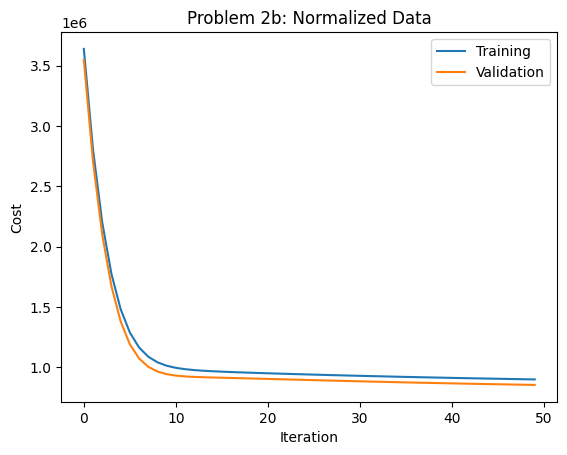

In [179]:
X_train = X_scaled["train_b_norm"]
X_validate = X_scaled["validate_b_norm"]

theta = np.zeros((X_train.shape[1], 1))

iterations = 1000
alpha = .1

theta, training_cost_history, validation_cost_history = grad_desc(X_train, Y_train, theta, alpha, iterations, X_validate, Y_validate)

display_loss(50, training_cost_history[:50], validation_cost_history[:50], "Problem 2b: Normalized Data")
cost_2b_norm = print_model(X_validate, Y_validate, theta, return_cost=True)

Model:
    Y = 256952.091*X11 + 222311.464*X10 + 405398.464*X9 + 188006.755*X8 + 145156.012*X7 + 148023.343*X6 + 212628.153*X5 + 361494.885*X4 + 578151.302*X3 + 73581.346*X2 + 537675.374*X1 + 4784210.274
    cost = 7.602334e+05


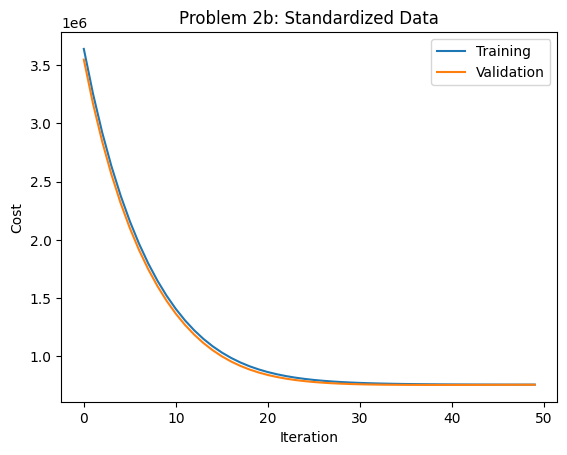

In [180]:
X_train = X_scaled["train_b_std"]
X_validate = X_scaled["validate_b_std"]

theta = np.zeros((X_train.shape[1], 1))

iterations = 1000
alpha = .1

theta, training_cost_history, validation_cost_history = grad_desc(X_train, Y_train, theta, alpha, iterations, X_validate, Y_validate)

display_loss(50, training_cost_history[:50], validation_cost_history[:50], "Problem 2b: Standardized Data")
cost_2b_std = print_model(X_validate, Y_validate, theta, return_cost=True)

Model:
    Y = 1235904.444*X5 + 1592810.492*X4 + 2875691.794*X3 + 1103758.127*X2 + 3509536.842*X1 + 2486294.014
    cost = 8.730049e+05
Percent improvement: 0.8246354035877552


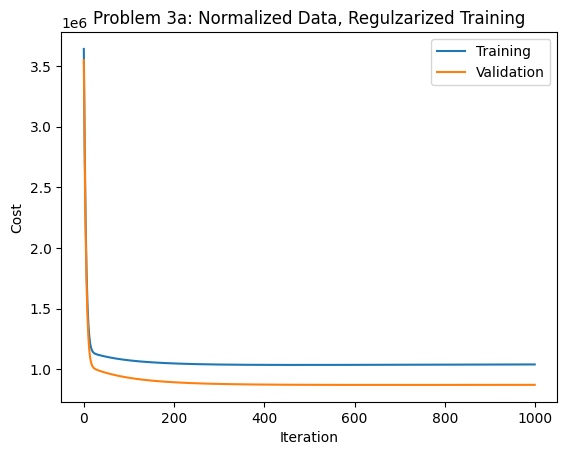

In [181]:
# Problem 3a
# Train on X_train_a_norm


X_train = X_scaled["train_a_norm"]
X_validate = X_scaled["validate_a_norm"]

theta = np.zeros((X_train.shape[1], 1))

iterations = 1000
alpha = .1

lambda_val = .009
theta, training_cost_history, validation_cost_history = grad_desc(X_train, Y_train, theta, alpha, iterations, X_validate, Y_validate, lambda_val = lambda_val)

cost = print_model(X_validate, Y_validate, theta, return_cost=True)

print(f"Percent improvement: {100*-(cost-cost_2_a_norm)/cost_2_a_norm}")
# print(f"Improved ? : {cost < cost_2_a}")
# print(f"Equal ? : {cost == cost_2_a}")
display_loss(iterations, training_cost_history, validation_cost_history, "Problem 3a: Normalized Data, Regulzarized Training")

By increasing to 1000 iterations, regularization can bring the cost down by 7.02%
    This is not simply due to the iteration increase. At lambda=0, the cost actually worsens by 0.3%
At 40 iterations, it is not possible to achieve significant improvement using regularization
Standardized data achieves a much lower improvement from regularization at a max of 0.97%

In [182]:
# Problem 3a
# Train on X_train_a_std


X_train = X_scaled["train_a_std"]
X_validate = X_scaled["validate_a_std"]

theta = np.zeros((X_train.shape[1], 1))

iterations = 1000
alpha = .1

lambda_val = 0.015

theta, training_cost_history, validation_cost_history = grad_desc(X_train, Y_train, theta, alpha, iterations, X_validate, Y_validate, lambda_val = lambda_val)

cost = print_model(X_validate, Y_validate, theta, return_cost=True)

print(f"Percent improvement: {100*-(cost-cost_2a_std)/cost_2a_std}")
# print(f"Improved ? : {cost < cost_2_a}")
# print(f"Equal ? : {cost == cost_2_a}")
#display_loss(iterations, training_cost_history, validation_cost_history, "Problem 3a: Standardized Data")

Model:
    Y = 290414.417*X5 + 452787.725*X4 + 634218.308*X3 + 81824.421*X2 + 725458.035*X1 + 4703251.597
    cost = 8.920735e+05
Percent improvement: 0.15496723710144503


In [183]:
# Problem 3b
# Train on X_train_a_norm


X_train = X_scaled["train_b_norm"]
X_validate = X_scaled["validate_b_norm"]

theta = np.zeros((X_train.shape[1], 1))

iterations = 1000
alpha = .1

lambda_val = 0.010
#1.89% at lambda=0


theta, training_cost_history, validation_cost_history = grad_desc(X_train, Y_train, theta, alpha, iterations, X_validate, Y_validate, lambda_val = lambda_val)

cost = print_model(X_validate, Y_validate, theta, return_cost=True)

print(f"Percent improvement: {100*-(cost-cost_2b_norm)/cost_2b_norm}")
# print(f"Improved ? : {cost < cost_2_a}")
# print(f"Equal ? : {cost == cost_2_a}")
#display_loss(iterations, training_cost_history, validation_cost_history, "Problem 3b: Normalized Data, Regulzarized Training")

Model:
    Y = 638829.235*X11 + 925611.091*X10 + 947196.905*X9 + 813180.317*X8 + 315360.362*X7 + 463601.861*X6 + 789481.647*X5 + 1231886.876*X4 + 2504939.893*X3 + 938067.602*X2 + 2375346.708*X1 + 1689186.934
    cost = 7.498947e+05
Percent improvement: 0.32271650232865895


Model:
    Y = 253607.607*X11 + 228116.704*X10 + 396139.844*X9 + 187250.705*X8 + 145390.301*X7 + 147197.3*X6 + 212292.698*X5 + 361055.748*X4 + 569748.729*X3 + 74164.081*X2 + 528002.074*X1 + 4680758.059
    cost = 7.563852e+05
Percent improvement: 0.5061820471657332


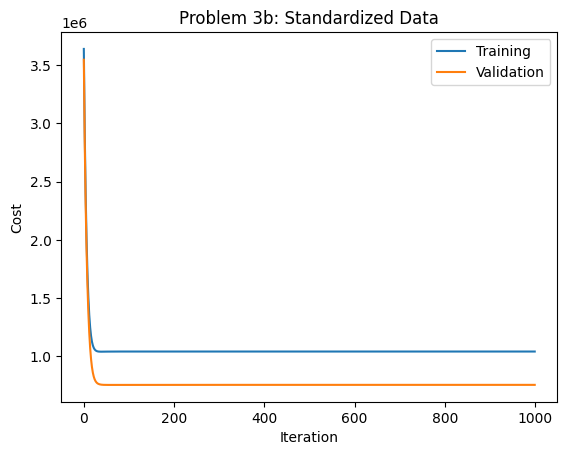

In [184]:
# Problem 3a
# Train on X_train_a_std


X_train = X_scaled["train_b_std"]
X_validate = X_scaled["validate_b_std"]

theta = np.zeros((X_train.shape[1], 1))

iterations = 1000
alpha = .1

lambda_val = 0.022
# Best is 15
#-0.96% at lambda = 0

theta, training_cost_history, validation_cost_history = grad_desc(X_train, Y_train, theta, alpha, iterations, X_validate, Y_validate, lambda_val = lambda_val)

cost = print_model(X_validate, Y_validate, theta, return_cost=True)

print(f"Percent improvement: {100*-(cost-cost_2b_std)/cost_2b_std}")
# print(f"Improved ? : {cost < cost_2_a}")
# print(f"Equal ? : {cost == cost_2_a}")
display_loss(iterations, training_cost_history, validation_cost_history, "Problem 3b: Standardized Data")

Increasing to 1000 iterations improves cost by 1.89% for normalized data and -0.96% for standardized
Once again, a much higher improvement is achieved witht the normalized data, reaching a max of 9% improvement compared to 0.23% for standardized
